In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
import matplotlib
matplotlib.rc('pdf', fonttype=42)

In [3]:
import matplotlib.pyplot as plt

import tools as t

/Users/dimazest/miniconda3/envs/notebook/lib/python3.5/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [4]:
!scp frank:/import/dima-scratch/phd-buildout/experiments/emnlp14/results_all.csv .

results_all.csv                               100%   16MB   7.9MB/s   00:02    


In [5]:
results = t.read_results()

# Max selection

/Users/dimazest/miniconda3/envs/notebook/lib/python3.5/site-packages/seaborn/categorical.py:1462: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  hue_mask = self.plot_hues[i] == hue_level
/Users/dimazest/miniconda3/envs/notebook/lib/python3.5/site-packages/seaborn/categorical.py:1464: VisibleDeprecationWarning: using a boolean instead of an integer will result in an error in the future
  stat_data = remove_na(group_data[hue_mask])


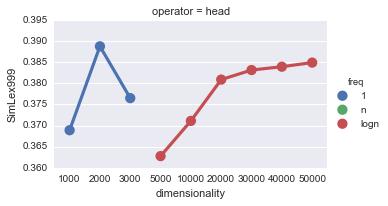

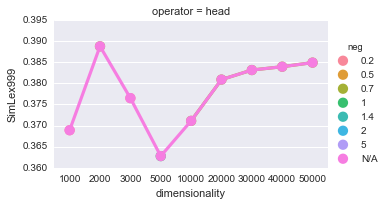

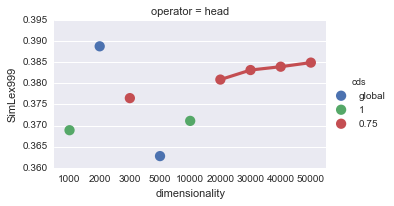

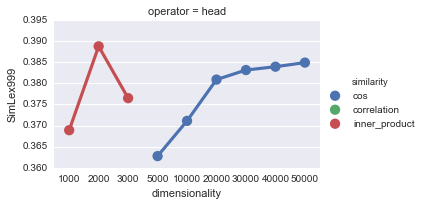

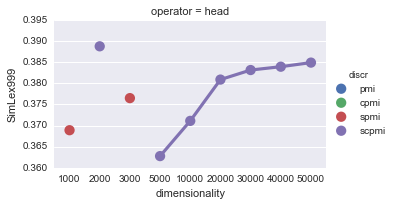

In [6]:
max_selection_simlex = t.plot_selection(
    results[results.index.get_level_values('operator') == 'head'],
    dataset='SimLex999',
    selector_function=t.max_('men'),
)

/Users/dimazest/miniconda3/envs/notebook/lib/python3.5/site-packages/seaborn/categorical.py:1462: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  hue_mask = self.plot_hues[i] == hue_level
/Users/dimazest/miniconda3/envs/notebook/lib/python3.5/site-packages/seaborn/categorical.py:1464: VisibleDeprecationWarning: using a boolean instead of an integer will result in an error in the future
  stat_data = remove_na(group_data[hue_mask])


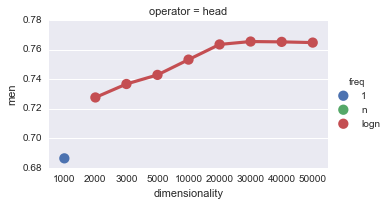

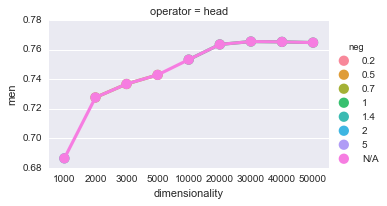

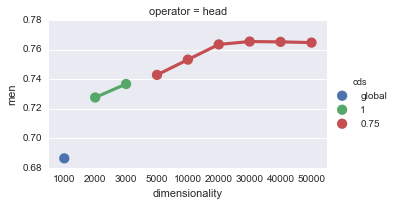

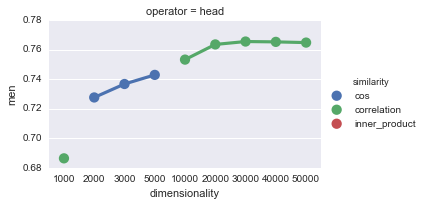

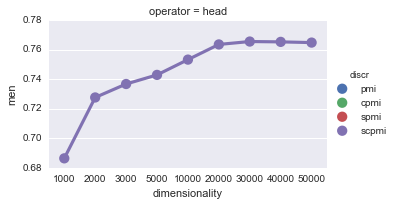

In [7]:
max_selection_men = t.plot_selection(
    results[results.index.get_level_values('operator') == 'head'],
    dataset='men',
    selector_function=t.max_('SimLex999'),
)

# Cross-validation

In [12]:
results.head()

fold_label                                                                                                   max  \
                                                                                                       SimLex999   
corpus           reduction cds  operator freq discr base context_type dimensionality neg similarity                
ukwac_wackypedia raw       0.75 add      1    cpmi       nvaa         1000           N/A correlation         NaN   
                                                                                         cos                 NaN   
                                                                                         inner_product       NaN   
                                                                      2000           N/A correlation         NaN   
                                                                                         cos                 NaN   

fold_label                                                                                               testing  \
                                                                                                       SimLex999   
corpus           reduction cds  operator freq discr base context_type dimensionality neg similarity                
ukwac_wackypedia raw       0.75 add      1    cpmi       nvaa         1000           N/A correlation         NaN   
                                                                                         cos                 NaN   
                                                                                         inner_product       NaN   
                                                                      2000           N/A correlation         NaN   
                                                                                         cos                 NaN   

fold_label                                                                                              training  \
                                                                                                       SimLex999   
corpus           reduction cds  operator freq discr base context_type dimensionality neg similarity                
ukwac_wackypedia raw       0.75 add      1    cpmi       nvaa         1000           N/A correlation         NaN   
                                                                                         cos                 NaN   
                                                                                         inner_product       NaN   
                                                                      2000           N/A correlation         NaN   
                                                                                         cos                 NaN   

fold_label                                                                                             max  \
                                                                                                       men   
corpus           reduction cds  operator freq discr base context_type dimensionality neg similarity          
ukwac_wackypedia raw       0.75 add      1    cpmi       nvaa         1000           N/A correlation   NaN   
                                                                                         cos           NaN   
                                                                                         inner_product NaN   
                                                                      2000           N/A correlation   NaN   
                                                                                         cos           NaN   

fold_label                                                                                             testing  \
                                                                                                           men   
corpus           reduction cds  operator freq discr base context_type dimensionality neg similarity     

/Users/dimazest/miniconda3/envs/notebook/lib/python3.5/site-packages/seaborn/categorical.py:1462: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  hue_mask = self.plot_hues[i] == hue_level
/Users/dimazest/miniconda3/envs/notebook/lib/python3.5/site-packages/seaborn/categorical.py:1464: VisibleDeprecationWarning: using a boolean instead of an integer will result in an error in the future
  stat_data = remove_na(group_data[hue_mask])


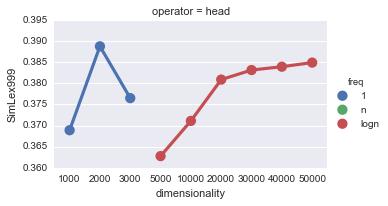

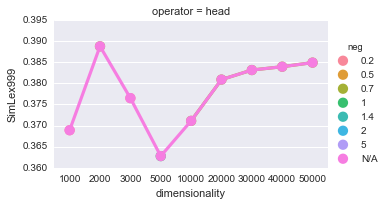

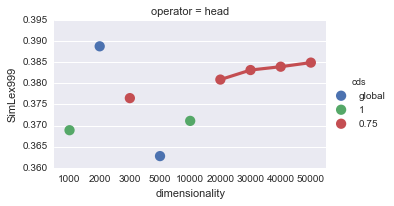

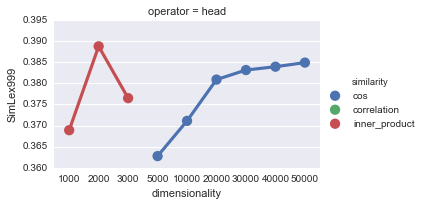

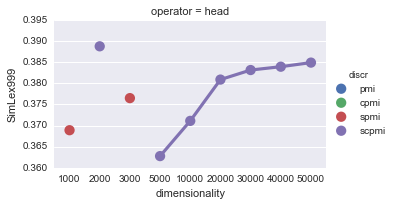

In [56]:
cross_validation_selection_simlex = t.plot_selection(
    results[results.index.get_level_values('operator') == 'head'],
    dataset='SimLex999',
    selector_function=t.cross_validation('men'),
)

/Users/dimazest/miniconda3/envs/notebook/lib/python3.5/site-packages/seaborn/categorical.py:1462: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  hue_mask = self.plot_hues[i] == hue_level
/Users/dimazest/miniconda3/envs/notebook/lib/python3.5/site-packages/seaborn/categorical.py:1464: VisibleDeprecationWarning: using a boolean instead of an integer will result in an error in the future
  stat_data = remove_na(group_data[hue_mask])


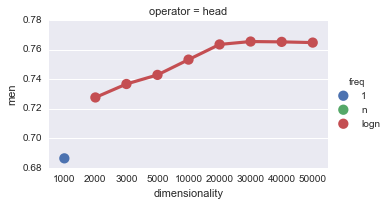

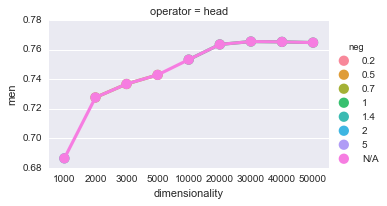

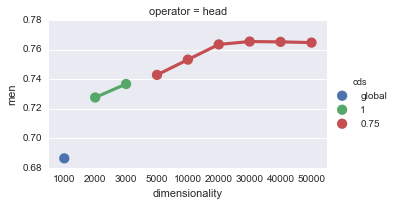

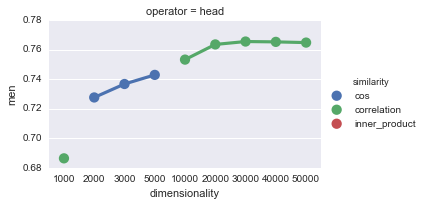

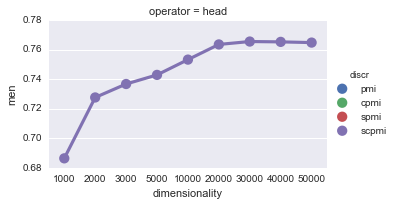

In [21]:
cross_validation_selection_men = t.plot_selection(
    results[results.index.get_level_values('operator') == 'head'],
    dataset='men',
    selector_function=t.cross_validation('SimLex999'),
)

# Heuristics

## SimLex-999

In [22]:
parameters = [
    'dimensionality', 'discr', 'cds', 'freq', 'neg', 'similarity',
]

In [23]:
t.anova(
    response='SimLex999',
    predictors=parameters,
    data=results,
).rsquared_adj

0.86701695238077925

In [24]:
feature_ablation_simlex = t.calculate_feature_ablation(
    responses=(
        'SimLex999',
        # 'men',
    ),
    predictors=parameters,
    data=results,
)

# feature_ablation.plot(kind='barh')#.get_figure().savefig('figures/emnlp2013_turk-parameter-ablation.pdf')
feature_ablation_simlex.sort_values(('partial R2', 'SimLex999'), ascending=False, inplace=True)

feature_ablation_simlex.round(3)

,partial R2
response,SimLex999
predictor,
similarity,0.379
freq,0.268
neg,0.241
dimensionality,0.083
discr,0.077
cds,0.064


In [25]:
heuristics_selection_collection_simlex = {}

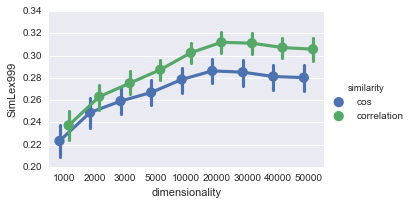

In [26]:
t.plot_interaction(results, feature_ablation_simlex.index[0], 'SimLex999')

In [27]:
assert feature_ablation_simlex.index[0] == 'similarity'
r = results['max'].reset_index()

heuristics_selection_collection_simlex[0] = r.loc[
    r['similarity'] == 'correlation'
]

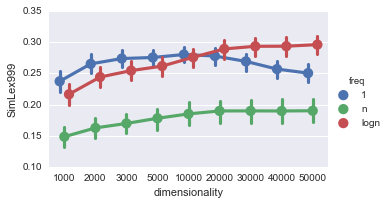

In [28]:
t.plot_interaction(results, feature_ablation_simlex.index[1], 'SimLex999')

In [29]:
assert feature_ablation_simlex.index[1] == 'freq'

r = heuristics_selection_collection_simlex[0]

heuristics_selection_collection_simlex[1] =  r.loc[
    (~(r['dimensionality'] < 20000) | (r['freq'] == '1')) &
    (~(r['dimensionality'] >= 20000) | (r['freq'] == 'logn')) &
    True
]

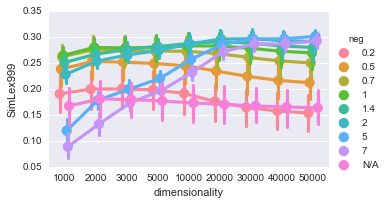

In [30]:
t.plot_interaction(results, feature_ablation_simlex.index[2], 'SimLex999')

In [31]:
assert feature_ablation_simlex.index[2] == 'neg'

r = heuristics_selection_collection_simlex[1]

heuristics_selection_collection_simlex[2] =  r.loc[
    # *coarse selection
    (~(r['dimensionality'] < 20000) | ((r['neg'] == 1) | (r['neg'] == 'N/A'))) &
    (~(r['dimensionality'] >= 20000) | ((r['neg'] == 5) | (r['neg'] == 'N/A'))) &
    True
]

In [32]:
# Skip dimensionality
assert feature_ablation_simlex.index[3] == 'dimensionality'

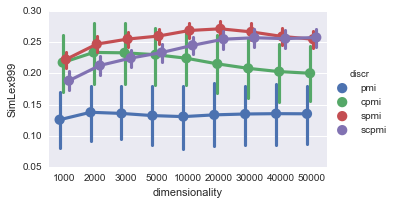

In [33]:
t.plot_interaction(results, feature_ablation_simlex.index[4], 'SimLex999')

In [34]:
assert feature_ablation_simlex.index[4] == 'discr'

r = heuristics_selection_collection_simlex[2]

heuristics_selection_collection_simlex[3] =  r.loc[
    # *skip tuning for 50K
    (~(r['dimensionality'] < 10000) | ((r['discr'] == 'cpmi'))) &
    (~(r['dimensionality'] >= 10000) | ((r['discr'] == 'spmi'))) &
    True
]

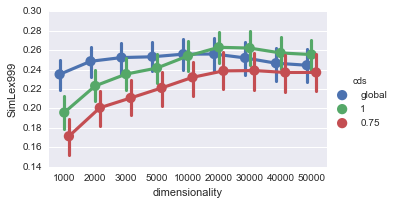

In [35]:
t.plot_interaction(results, feature_ablation_simlex.index[5], 'SimLex999')

In [36]:
assert feature_ablation_simlex.index[5] == 'cds'

r = heuristics_selection_collection_simlex[3]

heuristics_selection_collection_simlex[4] =  r.loc[
    # *skip tuning for 50K
    (~(r['dimensionality'] < 10000) | ((r['cds'] == 'global'))) &
    (~(r['dimensionality'] >= 10000) | ((r['cds'] == '1'))) &
    True
]

In [37]:
assert len(feature_ablation_simlex) == 6

In [38]:
heuristics_selection_simlex = heuristics_selection_collection_simlex[4].set_index(['operator', 'dimensionality'], drop=False)
heuristics_selection_simlex['selection'] = 'heuristics'

## MEN

In [39]:
t.anova(
    response='men',
    predictors=parameters,
    data=results,
).rsquared_adj

0.73306515868630373

In [40]:
feature_ablation_men = t.calculate_feature_ablation(
    responses=(
        'men',
    ),
    predictors=parameters,
    data=results,
)

# feature_ablation.plot(kind='barh')#.get_figure().savefig('figures/emnlp2013_turk-parameter-ablation.pdf')
feature_ablation_men.sort_values(('partial R2', 'men'), ascending=False, inplace=True)

feature_ablation_men.round(3)

,partial R2
response,men
predictor,
neg,0.309
freq,0.204
similarity,0.183
discr,0.119
dimensionality,0.108
cds,0.086


In [41]:
heuristics_selection_collection_men = {}

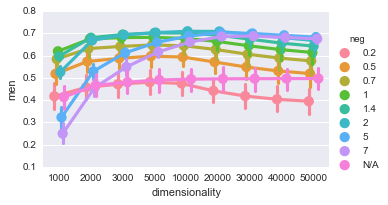

In [42]:
t.plot_interaction(results, feature_ablation_men.index[0], 'men')

In [43]:
assert feature_ablation_men.index[0] == 'neg'

r = results['max'].reset_index()

heuristics_selection_collection_men[0] =  r.loc[
    # *coarse selection
    (~(r['dimensionality'] < 20000) | ((r['neg'] == 2) | (r['neg'] == 'N/A'))) &
    (~(r['dimensionality'] >= 20000) | ((r['neg'] == 5) | (r['neg'] == 'N/A'))) &
    True
]

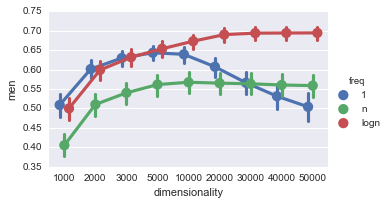

In [44]:
t.plot_interaction(results, feature_ablation_men.index[1], 'men')

In [45]:
assert feature_ablation_men.index[1] == 'freq'

r = heuristics_selection_collection_men[0]

heuristics_selection_collection_men[1] =  r.loc[
    (~(r['dimensionality'] < 3000) | (r['freq'] == '1')) &
    (~(r['dimensionality'] >= 3000) | (r['freq'] == 'logn')) &
    True
]

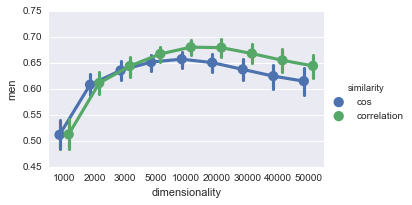

In [46]:
t.plot_interaction(results, feature_ablation_men.index[2], 'men')

In [47]:
assert feature_ablation_men.index[2] == 'similarity'

r = heuristics_selection_collection_men[1]

heuristics_selection_collection_men[2] =  r.loc[
    (~(r['dimensionality'] < 3000) | (r['similarity'] == 'cos')) &
    (~(r['dimensionality'] >= 3000) | (r['similarity'] == 'correlation')) &
    True
]

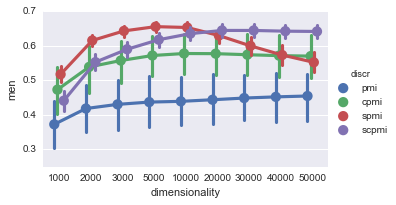

In [48]:
t.plot_interaction(results, feature_ablation_men.index[3], 'men')

In [49]:
assert feature_ablation_men.index[3] == 'discr'

r = heuristics_selection_collection_men[2]

heuristics_selection_collection_men[3] =  r.loc[
    (~(r['dimensionality'] < 20000) | (r['discr'] == 'spmi')) &
    (~(r['dimensionality'] >= 20000) | (r['discr'] == 'scpmi')) &
    True
]

In [50]:
# Skip dimensionality
assert feature_ablation_men.index[4] == 'dimensionality'

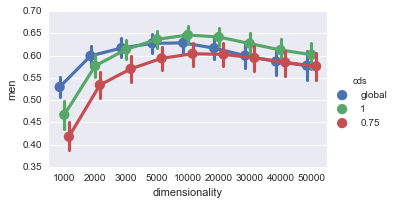

In [51]:
t.plot_interaction(results, feature_ablation_men.index[5], 'men')

In [52]:
assert feature_ablation_men.index[5] == 'cds'

r = heuristics_selection_collection_men[3]

heuristics_selection_collection_men[4] =  r.loc[
    (~(r['dimensionality'] < 5000) | (r['cds'] == 'global')) &
    (~(r['dimensionality'] >= 5000) | (r['cds'] == '1')) &
    True
]

In [53]:
assert len(feature_ablation_men) == 6

In [54]:
heuristics_selection_men = heuristics_selection_collection_men[4].set_index(['operator', 'dimensionality'], drop=False)
heuristics_selection_men['selection'] = 'heuristics'

#  Parameter selection comparison

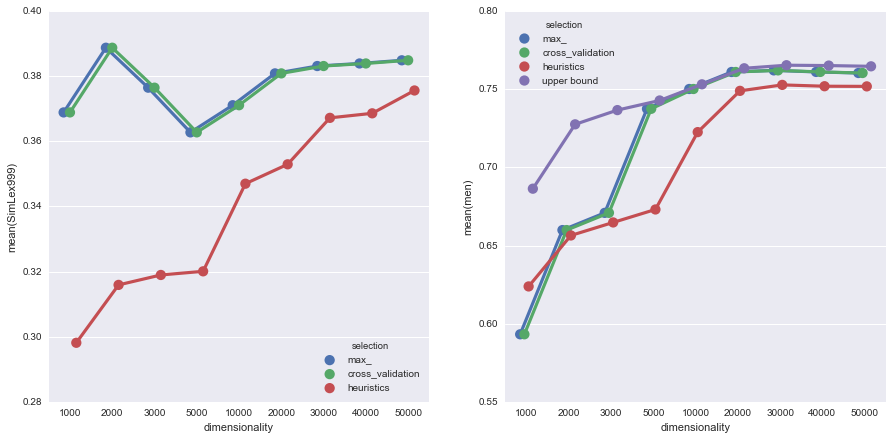

In [57]:
f, axarr = plt.subplots(1, 2, sharex=True, figsize=(15, 7))

t.plot_parameter_selection_comparison(
    [
        max_selection_simlex,
        cross_validation_selection_simlex,
        heuristics_selection_simlex,
    ],
    'SimLex999',
    ax=axarr[0]
)

t.plot_parameter_selection_comparison(
    [
        max_selection_simlex,
        cross_validation_selection_simlex,
        heuristics_selection_simlex,

        max_selection_men.assign(selection='upper bound')
    ],
    'SimLex999',
    'men',
    ax=axarr[1]
)

In [64]:
(max_selection_simlex['SimLex999'] - cross_validation_selection_simlex['SimLex999']).mean()

0.0

In [65]:
(max_selection_simlex['SimLex999'] - heuristics_selection_simlex['SimLex999']).mean()

0.037378888888888885

In [69]:
(max_selection_men['men'] - max_selection_simlex['men']).mean()

0.027665555555555523

In [70]:
(max_selection_men['men'] - cross_validation_selection_simlex['men']).mean()

0.027665555555555523

In [71]:
(max_selection_men['men'] - heuristics_selection_simlex['men']).mean()

0.039894444444444427

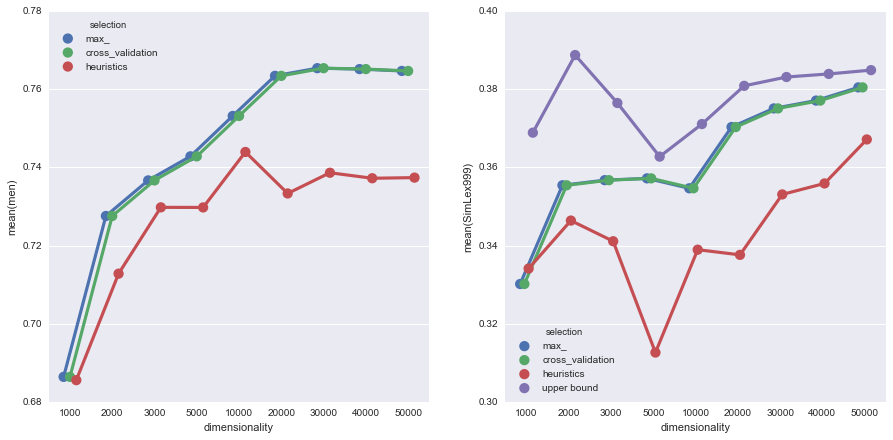

In [58]:
f, axarr = plt.subplots(1, 2, sharex=True, figsize=(15, 7))

t.plot_parameter_selection_comparison(
    [
        max_selection_men,
        cross_validation_selection_men,
        heuristics_selection_men,
    ],
    'men',
    ax=axarr[0]
)

t.plot_parameter_selection_comparison(
    [
        max_selection_men,
        cross_validation_selection_men,
        heuristics_selection_men,

        max_selection_simlex.assign(selection='upper bound')
    ],
    'men',
    'SimLex999',
    ax=axarr[1]
)

In [66]:
(max_selection_men['men'] - cross_validation_selection_men['men']).mean()

0.0

In [67]:
(max_selection_men['men'] - heuristics_selection_men['men']).mean()

0.017438888888888879

In [72]:
(max_selection_simlex['SimLex999'] - max_selection_men['SimLex999']).mean()

0.015965555555555552

In [73]:
(max_selection_simlex['SimLex999'] - cross_validation_selection_men['SimLex999']).mean()

0.015965555555555552

In [74]:
(max_selection_simlex['SimLex999'] - heuristics_selection_men['SimLex999']).mean()

0.034890000000000004